In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)
pd.set_option('display.float_format', '{:.2f}'.format)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point

from sklearn.neighbors import BallTree
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
path = '/Users/tristangarcia/desktop/hp-pred/data/wa/'

In [3]:
train = pd.read_pickle(f'{path}wa_train_clean.pkl')
test = pd.read_pickle(f'{path}wa_validation_clean.pkl')    # validation set

In [4]:
train.shape

(108128, 14)

In [5]:
train.head()

,streetNumber,street,suburb,postcode,bathrooms,bedrooms,parking,landArea,latitude,longitude,features,propertyType,soldYear,soldPrice
0,18,townsend road,rockingham,6168.00,2,4,3,684.00,-32.29,115.73,[],house,2022.00,537500.00
1,1,mckivett crescent,leeming,6149.00,2,4,2,739.00,-32.08,115.85,[],house,2019.00,635000.00
2,72,oceanside promenade,mullaloo,6027.00,2,6,2,719.00,-31.78,115.73,"[air conditioning, balcony / deck, built in wardrobes, close to schools, close to shops, close to transport, garden, swimming pool, secure parking]",house,2023.00,2025000.00
3,19,raymond street,yokine,6060.00,1,2,1,62.00,-31.90,115.84,[],unit,2022.00,220000.00
4,1,eucumbene crescent,joondalup,6027.00,1,3,1,651.00,-31.72,115.77,"[life style, value]",house,2021.00,421000.00


In [6]:
train.columns

Index(['streetNumber', 'street', 'suburb', 'postcode', 'bathrooms', 'bedrooms',
       'parking', 'landArea', 'latitude', 'longitude', 'features',
       'propertyType', 'soldYear', 'soldPrice'],
      dtype='object')

# Sold Price

In [7]:
train['propertyType'].value_counts()

propertyType
house    94819
unit     13309
Name: count, dtype: int64

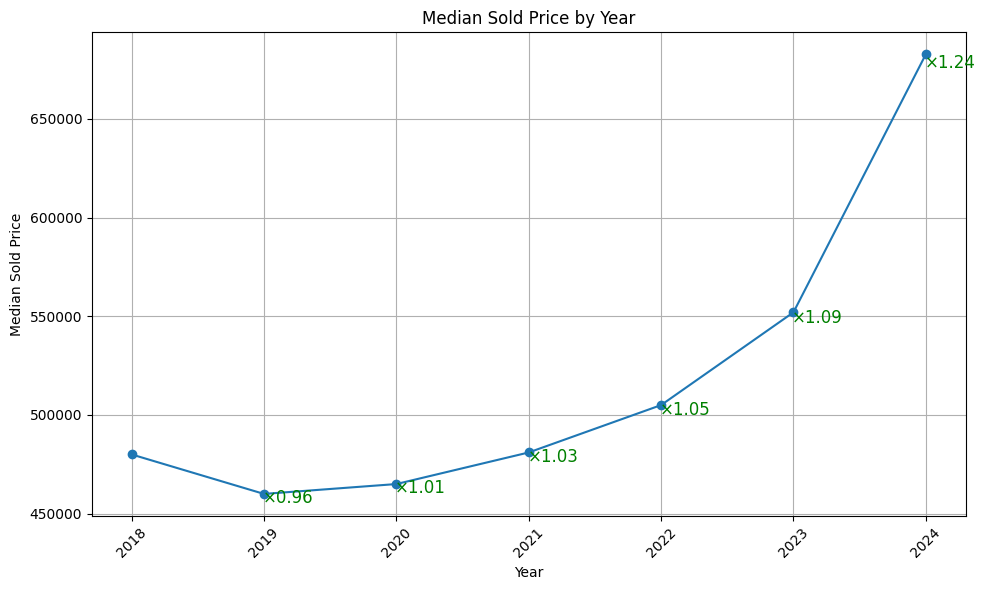

In [8]:
# Group by soldYear and calculate the median soldPrice for each year
median_prices_by_year = train.groupby('soldYear')['soldPrice'].median().reset_index()
median_prices_by_year['scaling_factor'] = median_prices_by_year['soldPrice'].pct_change() + 1


# Plot the median sold price by year
plt.figure(figsize=(10, 6))
plt.plot(median_prices_by_year['soldYear'], median_prices_by_year['soldPrice'], marker='o')
# Adding text annotations for median_prices_by_year factors with offsets
for i in range(1, len(median_prices_by_year)):
    x_offset = -0.01  # slight lefttward shift
    y_offset = median_prices_by_year['soldPrice'].iloc[i] * -0.01  # slightly below the point

    plt.text(median_prices_by_year['soldYear'].iloc[i] + x_offset, 
             median_prices_by_year['soldPrice'].iloc[i] + y_offset,
             f"×{median_prices_by_year['scaling_factor'].iloc[i]:.2f}",
             color='green', fontsize=12)
    
plt.title('Median Sold Price by Year')
plt.xlabel('Year')
plt.ylabel('Median Sold Price')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the year labels if needed
plt.tight_layout()

Seeing as there is a massive difference in median prices throughout the years, we will adjust to match the price for 2024. We will build a dataframe of the median house prices per year and property type and a scaling factor for how much to adjust them by to match 2024

In [9]:
# Calculate median sold prices by 'soldYear' and 'propertyType'
median_prices = train.groupby(['soldYear', 'propertyType'])['soldPrice'].median().reset_index()
median_prices.rename(columns={'soldPrice': 'medianSoldPrice'}, inplace=True)

# Using the most recent year as a reference to scale values to
latest_year = train['soldYear'].max()   # Used instead of hardcoding 2024 for reproducibility in later years
reference_medians = median_prices[median_prices['soldYear'] == latest_year]

# Merge the reference medians back to the median prices DataFrame
median_prices = median_prices.merge(reference_medians, on='propertyType', suffixes=('', '_ref'))

# Calculate scaling factors
median_prices['scalingFactor'] = median_prices['medianSoldPrice_ref'] / median_prices['medianSoldPrice']

In [10]:
median_prices.columns

Index(['soldYear', 'propertyType', 'medianSoldPrice', 'soldYear_ref',
       'medianSoldPrice_ref', 'scalingFactor'],
      dtype='object')

In [11]:
median_prices.head()

,soldYear,propertyType,medianSoldPrice,soldYear_ref,medianSoldPrice_ref,scalingFactor
0,2018.00,house,495000.00,2024.00,720000.00,1.45
1,2018.00,unit,330000.00,2024.00,465000.00,1.41
2,2019.00,house,475000.00,2024.00,720000.00,1.52
3,2019.00,unit,314500.00,2024.00,465000.00,1.48
4,2020.00,house,480000.00,2024.00,720000.00,1.50


In [12]:
# Apply the scaling factors to the training set
train = train.merge(median_prices[['soldYear', 'propertyType', 'scalingFactor']], on=['soldYear', 'propertyType'], how='left')
train['adjustedPrice'] = train['soldPrice'] * train['scalingFactor']

# Apply the same scaling factors to the test set
test = test.merge(median_prices[['soldYear', 'propertyType', 'scalingFactor']], on=['soldYear', 'propertyType'], how='left')
test['adjustedPrice'] = test['soldPrice'] * test['scalingFactor']

In [13]:
print(train[['soldYear', 'propertyType', 'soldPrice', 'adjustedPrice']].head())
print(test[['soldYear', 'propertyType', 'soldPrice', 'adjustedPrice']].head())

   soldYear propertyType  soldPrice  adjustedPrice
0   2022.00        house  537500.00      737142.86
1   2019.00        house  635000.00      962526.32
2   2023.00        house 2025000.00     2492307.69
3   2022.00         unit  220000.00      288983.05
4   2021.00        house  421000.00      606240.00
   soldYear propertyType  soldPrice  adjustedPrice
0   2022.00        house  910000.00     1248000.00
1   2021.00        house  192000.00      276480.00
2   2024.00        house 1830000.00     1830000.00
3   2022.00        house  755000.00     1035428.57
4   2022.00        house  700000.00      960000.00


In [14]:
median_prices[(median_prices['soldYear']==2022) & (median_prices['propertyType']=='house')]

,soldYear,propertyType,medianSoldPrice,soldYear_ref,medianSoldPrice_ref,scalingFactor
8,2022.00,house,525000.00,2024.00,720000.00,1.37


In [15]:
# Checking that this equals to 1.28
round(737142.86/537500.00,2)

1.37

In [16]:
suburbs_path = '/Users/tristangarcia/desktop/hp-pred/data/'
median_prices.to_csv(f'{suburbs_path}wa_price_scalers.csv',index=False)

In [17]:
# Removing helper columns and older soldPrice
train.drop(columns=['soldPrice','scalingFactor'], inplace=True)
test.drop(columns=['soldPrice','scalingFactor'], inplace=True)

# Renaming brand new adjustedPrice to soldPrice
train.rename(columns={'adjustedPrice': 'soldPrice'}, inplace=True)
test.rename(columns={'adjustedPrice': 'soldPrice'}, inplace=True)

# Suburb features

### Statistics

In [18]:
# Loading dataset
suburbs_path = '/Users/tristangarcia/desktop/hp-pred/data/'
suburb_statistics = pd.read_csv(f'{suburbs_path}wa_suburb_statistics.csv').fillna(0)

# Subsetting columns
suburb_statistics = suburb_statistics[['suburb', 'marriedPercentage', 'population',
                                       'renterPercentage', 'mostCommonAgeBracket']]

# Renaming columns to add 'suburb_' prefix, ensuring 'suburb' remains unchanged
suburb_statistics.columns = ['suburb' if col == 'suburb' else 'suburb_' + col for col in suburb_statistics.columns]


In [19]:
suburb_statistics[suburb_statistics['suburb_mostCommonAgeBracket'].apply(lambda x: isinstance(x, int))]

,suburb,suburb_marriedPercentage,suburb_population,suburb_renterPercentage,suburb_mostCommonAgeBracket
0,gibson desert north,0.00,0.00,0.00,0
1,gibson desert south,0.00,0.00,0.00,0
2,irrunytju,0.00,0.00,0.00,0
3,kanpa,0.00,0.00,0.00,0
4,kiwirrkurra,0.00,0.00,0.00,0
...,...,...,...,...,...
1810,midland dc,0.00,0.00,0.00,0
1811,malaga dc,0.00,0.00,0.00,0
1812,royal australian navy warships,0.00,0.00,0.00,0
1813,myaree bc,0.00,0.00,0.00,0


In [20]:
# Merging train and test
train = pd.merge(train, suburb_statistics, on=['suburb'], how='left').fillna(0)
test = pd.merge(test, suburb_statistics, on=['suburb'], how='left').fillna(0)

train['suburb_mostCommonAgeBracket'] = train['suburb_mostCommonAgeBracket'].astype(str)
test['suburb_mostCommonAgeBracket'] = test['suburb_mostCommonAgeBracket'].astype(str)


In [21]:
train.columns

Index(['streetNumber', 'street', 'suburb', 'postcode', 'bathrooms', 'bedrooms',
       'parking', 'landArea', 'latitude', 'longitude', 'features',
       'propertyType', 'soldYear', 'soldPrice', 'suburb_marriedPercentage',
       'suburb_population', 'suburb_renterPercentage',
       'suburb_mostCommonAgeBracket'],
      dtype='object')

### Prices
In this segment, we will create variables call 'suburb_medianPrice','suburb_entryLevelPrice','suburb_luxuryLevelPrice'. This will be done by grouping the training data by suburb, propertyType and bedroom. Calculations for each group will be applied to created a stats table (suburb_prices) which will be merged to the train and test sets


In [22]:
# Loading the dataset
suburbs_path = '/Users/tristangarcia/desktop/hp-pred/data/'
suburb_prices = pd.read_csv(f'{suburbs_path}wa_suburb_prices.csv').fillna(0)

This dataset that was scraped from domain.com.au has alot of missing values. We will find the median ratio that houses change in price from having one more or one less bedroom.

For example:
- propertyType, no. of bedrooms, suburb median price
- house, 3 bedrooms, 100 000
- house, 4 bedrooms, NaN

If the ratio is 20%, we will fill NaN with 100 000 * 1.20

In [23]:
def plot_suburb_prices(df,feature, feature_name):
    # Filtering to ensure we're only looking at positive prices
    df = df[df[feature] > 0]

    # Prepare data by grouping by the number of bedrooms and calculating the median sold price for each group
    price_by_bedrooms = df.groupby('bedrooms')[feature].median().reset_index()

    # Calculate scaling factors (ratios of consecutive median prices)
    price_by_bedrooms['scaling_factor'] = price_by_bedrooms[feature].pct_change() + 1

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(price_by_bedrooms['bedrooms'], price_by_bedrooms[feature], color='blue')
    plt.plot(price_by_bedrooms['bedrooms'], price_by_bedrooms[feature], color='red')

    # Adding text annotations for scaling factors with offsets
    for i in range(1, len(price_by_bedrooms)):
        # Offset values can be adjusted here
        x_offset = -0.1  # slight rightward shift
        y_offset = price_by_bedrooms[feature].iloc[i] * -0.05  # slightly above the point

        plt.text(price_by_bedrooms['bedrooms'].iloc[i] + x_offset, 
                 price_by_bedrooms[feature].iloc[i] + y_offset,
                 f"×{price_by_bedrooms['scaling_factor'].iloc[i]:.2f}",
                 color='green', fontsize=12)

    plt.title(f'{feature_name} vs. Number of Bedrooms (Scaling Factors)')
    plt.xlabel('Number of Bedrooms')
    plt.ylabel(f'{feature_name}')
    plt.grid(True)
    plt.show()

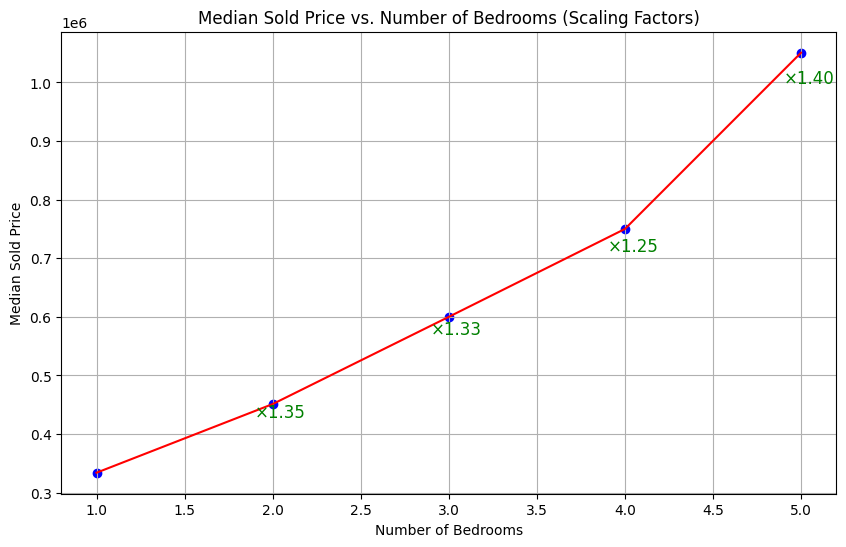

In [24]:
plot_suburb_prices(suburb_prices,'medianSoldPrice', 'Median Sold Price')

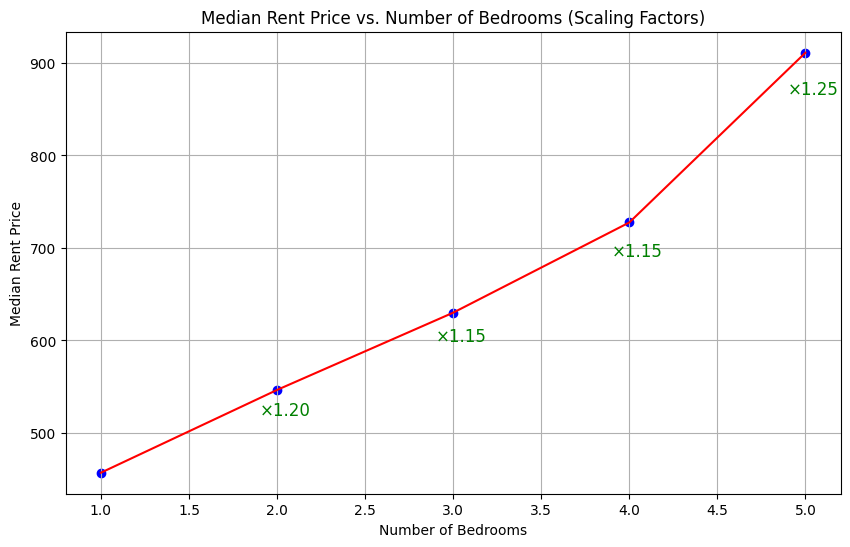

In [25]:
plot_suburb_prices(suburb_prices,'medianRentPrice', 'Median Rent Price')

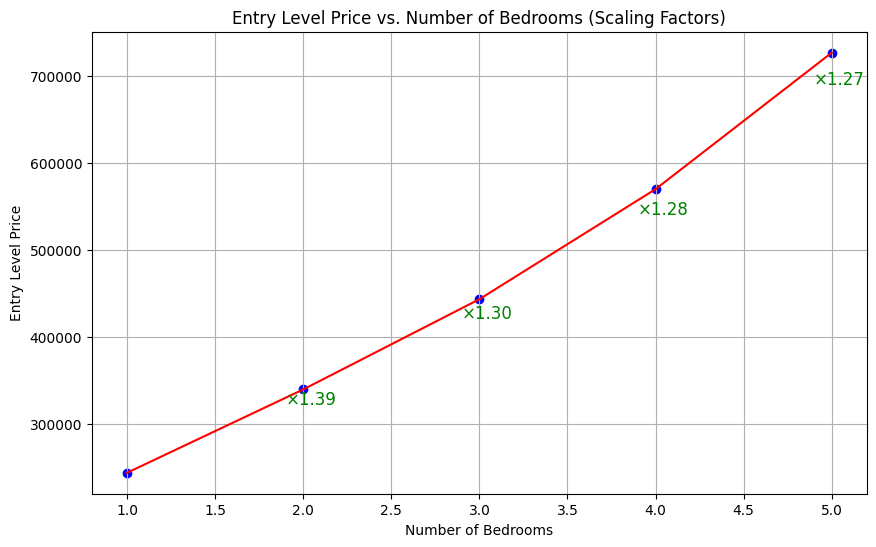

In [26]:
plot_suburb_prices(suburb_prices,'entryLevelPrice', 'Entry Level Price')

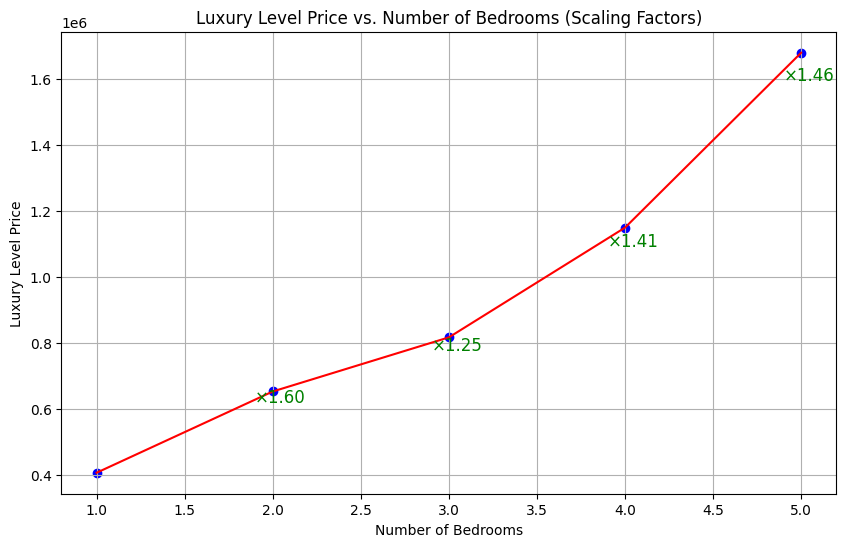

In [27]:
plot_suburb_prices(suburb_prices,'luxuryLevelPrice', 'Luxury Level Price')

In [28]:
suburb_prices[suburb_prices['suburb']=='northbridge']

,suburb,state,postcode,bedrooms,propertyType,medianSoldPrice,medianRentPrice,entryLevelPrice,luxuryLevelPrice,avgDaysListed
14,northbridge,wa,6003,2,house,488000.00,690.00,400000.00,585000.00,58
15,northbridge,wa,6003,3,house,649040.00,786.60,520000.00,731250.00,0
16,northbridge,wa,6003,4,house,843752.00,928.19,691600.00,1067625.00,0
17,northbridge,wa,6003,5,house,1198127.84,1169.52,899080.00,1612113.75,0
18,northbridge,wa,6003,1,unit,370769.23,550.00,325757.58,387333.33,0
19,northbridge,wa,6003,2,unit,482000.00,650.00,430000.00,581000.00,14
20,northbridge,wa,6003,3,unit,641060.00,741.00,559000.00,726250.00,0


In [29]:
# Define separate scaling factors for each feature, including both directions
scaling_factors_sold = {
    (1, 2): 1/1.30,
    (2, 1): 1.30,
    (2, 3): 1/1.33,
    (3, 2): 1.33,
    (3, 4): 1/1.30,
    (4, 3): 1.30,
    (4, 5): 1/1.42,
    (5, 4): 1.42
}

scaling_factors_rent = {
    (1, 2): 1/1.19,
    (2, 1): 1.19,
    (2, 3): 1/1.14,
    (3, 2): 1.14,
    (3, 4): 1/1.18,
    (4, 3): 1.18,
    (4, 5): 1/1.26,
    (5, 4): 1.26
}

scaling_factors_entry = {
    (1, 2): 1/1.32,
    (2, 1): 1.32,
    (2, 3): 1/1.30,
    (3, 2): 1.30,
    (3, 4): 1/1.33,
    (4, 3): 1.33,
    (4, 5): 1/1.30,
    (5, 4): 1.30
}

scaling_factors_luxury = {
    (1, 2): 1/1.50,
    (2, 1): 1.50,
    (2, 3): 1/1.25,
    (3, 2): 1.25,
    (3, 4): 1/1.46,
    (4, 3): 1.46,
    (4, 5): 1/1.51,
    (5, 4): 1.51
}


In [30]:
# Function to fill zeros based on scaled values of other bedroom counts
def fill_scaled_prices(row, feature, scale_factors):
    '''
    Fills zero values for various pricing features by estimating prices based on scaled values
    from properties with one more or one fewer bedroom, grouped by suburb and property type.
    It uses scaling factors that reflect how property prices typically adjust based on bedroom count changes.
    '''
    current_bedrooms = row['bedrooms']
    current_suburb = row['suburb']
    current_type = row['propertyType']
    
    if row[feature] == 0:
        # Check both possibilities: scaling up and scaling down
        for delta in [-1, 1]:  # Check one less and one more bedroom
            neighbor_bedrooms = current_bedrooms + delta
            scale_factor = scale_factors.get((current_bedrooms, neighbor_bedrooms))
            if scale_factor:
                # Get reference price from same suburb and property type with neighbor bedroom count
                ref_price = suburb_prices.loc[
                    (suburb_prices['suburb'] == current_suburb) & 
                    (suburb_prices['propertyType'] == current_type) &
                    (suburb_prices['bedrooms'] == neighbor_bedrooms), feature].median()
                
                if pd.notna(ref_price) and ref_price > 0:
                    return ref_price * scale_factor
    return row[feature]

# List of features to apply the function to and their corresponding scaling factors
features_scaling_dict = {
    'medianSoldPrice': scaling_factors_sold,
    'medianRentPrice': scaling_factors_rent,
    'entryLevelPrice': scaling_factors_entry,
    'luxuryLevelPrice': scaling_factors_luxury
}

for i in range(3):
    # Apply the function to each feature
    for feature, scales in features_scaling_dict.items():
        suburb_prices[feature] = suburb_prices.apply(lambda row: fill_scaled_prices(row, feature, scales), axis=1)

In [31]:
suburb_prices[suburb_prices['suburb']=='northbridge']

,suburb,state,postcode,bedrooms,propertyType,medianSoldPrice,medianRentPrice,entryLevelPrice,luxuryLevelPrice,avgDaysListed
14,northbridge,wa,6003,2,house,488000.00,690.00,400000.00,585000.00,58
15,northbridge,wa,6003,3,house,649040.00,786.60,520000.00,731250.00,0
16,northbridge,wa,6003,4,house,843752.00,928.19,691600.00,1067625.00,0
17,northbridge,wa,6003,5,house,1198127.84,1169.52,899080.00,1612113.75,0
18,northbridge,wa,6003,1,unit,370769.23,550.00,325757.58,387333.33,0
19,northbridge,wa,6003,2,unit,482000.00,650.00,430000.00,581000.00,14
20,northbridge,wa,6003,3,unit,641060.00,741.00,559000.00,726250.00,0


In [32]:
# Writing to the same filename to replace the old file
suburbs_path = '/Users/tristangarcia/desktop/hp-pred/data/'
suburb_prices.to_csv(f'{suburbs_path}wa_suburb_prices.csv', index=False)

In [33]:
merge_keys = ['suburb', 'bedrooms', 'propertyType']
suburb_prices = suburb_prices[['suburb','bedrooms','propertyType','medianSoldPrice','medianRentPrice','entryLevelPrice','luxuryLevelPrice']]
suburb_prices.columns = [f'suburb_{col}' if col not in merge_keys else col for col in suburb_prices.columns]

# Merge the enriched suburb_prices data with train and test data
train = pd.merge(train, suburb_prices, on=['suburb', 'bedrooms','propertyType'], 
                 how='left').fillna(0)
test = pd.merge(test, suburb_prices, on=['suburb','bedrooms','propertyType'],
                how='left').fillna(0)

# School features

In [34]:
school_path = '/Users/tristangarcia/desktop/hp-pred/data/school/'
school_icsea = pd.read_csv(f'{school_path}school_icsea.csv')
school_loc = pd.read_csv(f'{school_path}school_location.csv')

In [35]:
#### Preprocessing school_icsea data ####

# Subsetting columns
school_icsea = school_icsea[['School Name', 'Suburb', 'State','School Sector', 'ICSEA']]
# Lowercasing all string values
school_icsea = school_icsea.map(lambda x: x.lower() if isinstance(x,str) else x)
# Changing 'independent' sector to 'private'
school_icsea['School Sector'] = school_icsea['School Sector'].map(lambda x: 'private' if x=='independent' else x)
# Renaming columns
school_icsea.rename(columns={'School Name':'school','Suburb':'suburb','State':'state',
                        'School Sector':'sector','ICSEA':'icsea'}, inplace=True)

In [36]:
#### Preprocessing school_loc data ####

# Subsetting columns
school_loc = school_loc[['School Name', 'Suburb', 'State','School Sector', 'School Type', 'Latitude', 'Longitude']]
# Lowercasing all string values
school_loc = school_loc.map(lambda x: x.lower() if isinstance(x,str) else x)
# Changing 'Independent' sector to 'private'
school_loc['School Sector'] = school_loc['School Sector'].map(lambda x: 'private' if x=='independent' else x)
# Renaming columns
school_loc.rename(columns={'School Name':'school','Suburb':'suburb','State':'state','School Sector':'sector',
                           'School Type':'type','Latitude':'latitude','Longitude':'longitude'}, inplace=True)

In [37]:
school_icsea.shape

(9829, 5)

In [38]:
school_loc.shape

(10926, 7)

In [39]:
# Merging the two dataframes with a left join
# length of school_loc was greater than school_icsea, so not all school locations listed have icsea
school = pd.merge(
    school_loc,  
    school_icsea, 
    on=['school', 'suburb', 'state', 'sector'], 
    how='left'
)

In [40]:
school.isnull().sum()

school          0
suburb          0
state           0
sector          0
type            0
latitude        0
longitude       0
icsea        1436
dtype: int64

In [41]:
school['icsea'] = school['icsea'].fillna(0)

In [42]:
# Writing combined files to another file
school_path = '/Users/tristangarcia/Desktop/hp-pred/data/'
school.to_csv(f'{path}wa_school.csv', index=False)

In [43]:
def add_nearest_school_details(df, schools, school_type):
    # Filter schools by state and type
    filtered_schools = schools[
        (schools['state'] == 'wa') & 
        ((schools['type'] == school_type) | (schools['type'] == 'combined'))
    ][['school', 'type', 'sector', 'latitude', 'longitude', 'icsea']]

    # Convert lat/lon to radians for BallTree
    df_coords = np.radians(df[['latitude', 'longitude']].values)
    schools_coords = np.radians(filtered_schools[['latitude', 'longitude']].values)

    # Build BallTree using Haversine distance
    tree = BallTree(schools_coords, metric='haversine')

    # Query nearest neighbors (results are in radians; multiply by Earth radius for meters)
    distances, indices = tree.query(df_coords, k=1)
    distances_m = distances.flatten() * 6371000  # Earth radius in meters

    # Extract details of the nearest schools
    nearest_schools = filtered_schools.iloc[indices.flatten()].reset_index()
    nearest_schools['distance_m'] = distances_m  # Add distances in meters

    # Map results back to df
    df[f'{school_type}_school'] = nearest_schools['school'].values
    df[f'{school_type}Distance'] = nearest_schools['distance_m'].values
    df[f'{school_type}Type'] = nearest_schools['type'].values
    df[f'{school_type}ICSEA'] = nearest_schools['icsea'].fillna(0).values

    return df


In [44]:
# Adding school data to the train and test dataset
train = add_nearest_school_details(train, school, 'primary')
train = add_nearest_school_details(train, school, 'secondary')
test = add_nearest_school_details(test, school, 'primary')
test = add_nearest_school_details(test, school, 'secondary')

In [45]:
train[['primary_school', 'primaryICSEA','secondary_school','secondaryICSEA']].head()

,primary_school,primaryICSEA,secondary_school,secondaryICSEA
0,star of the sea primary school,1039.00,rockingham senior high school,960.00
1,leeming primary school,1106.00,leeming senior high school,1071.00
2,mullaloo beach primary school,1072.00,alta-1 college - mullaloo campus,0.00
3,tuart hill primary school,1070.00,servite college,1052.00
4,joondalup primary school,1021.00,lake joondalup baptist college,1109.00


In [46]:
train[['primary_school', 'primaryDistance','secondary_school','secondaryDistance']].head()

,primary_school,primaryDistance,secondary_school,secondaryDistance
0,star of the sea primary school,333.38,rockingham senior high school,708.97
1,leeming primary school,1017.58,leeming senior high school,721.97
2,mullaloo beach primary school,331.16,alta-1 college - mullaloo campus,1099.75
3,tuart hill primary school,394.66,servite college,1117.76
4,joondalup primary school,503.99,lake joondalup baptist college,1373.15


# Feature transformation

<Axes: ylabel='soldPrice'>

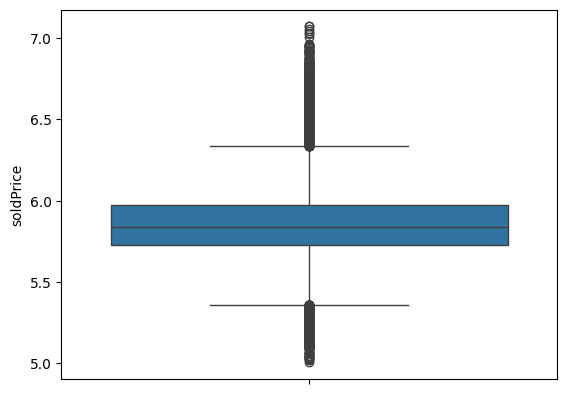

In [47]:
sns.boxplot(np.log10(train['soldPrice']))

In [48]:
train['soldPrice'] = train['soldPrice'].apply(lambda x: x if x == 0 else np.log10(x))
test['soldPrice'] = test['soldPrice'].apply(lambda x: x if x == 0 else np.log10(x))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: ylabel='landArea'>

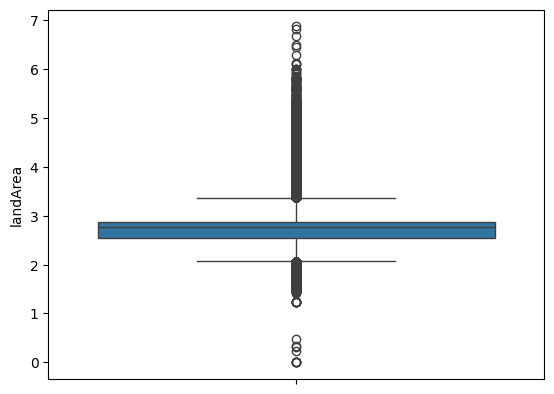

In [49]:
sns.boxplot(np.log10((train['landArea'])))

In [50]:
train['landArea'] = train['landArea'].apply(lambda x: x if x == 0 else np.log10(x))
test['landArea'] = test['landArea'].apply(lambda x: x if x == 0 else np.log10(x))

<Axes: xlabel='landArea', ylabel='Count'>

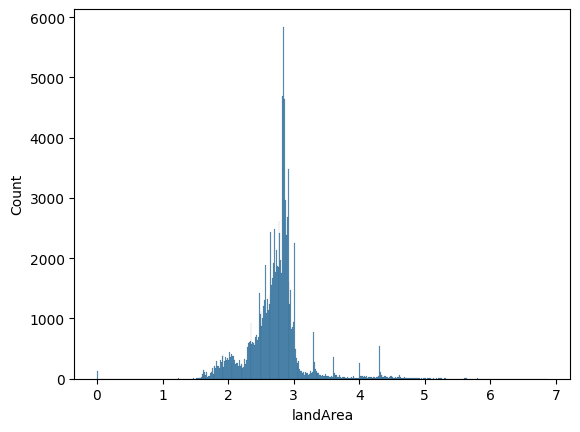

In [51]:
sns.histplot(train['landArea'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='suburb_medianSoldPrice', ylabel='Count'>

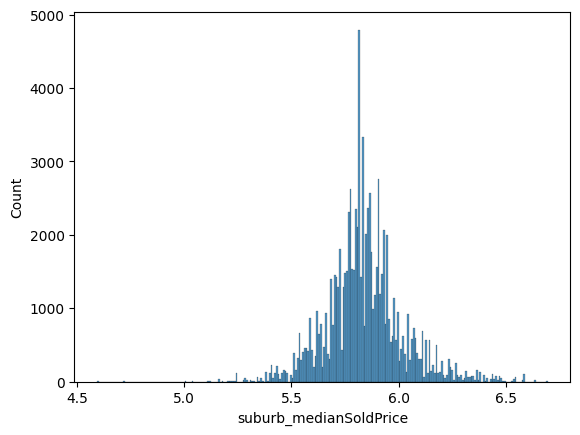

In [52]:
sns.histplot(np.log10(train['suburb_medianSoldPrice']))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='suburb_medianRentPrice', ylabel='Count'>

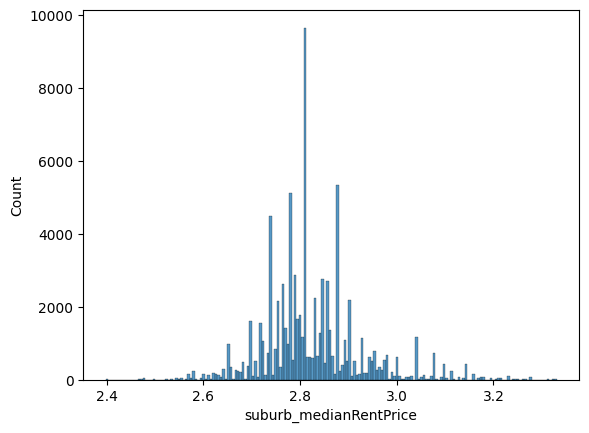

In [53]:
sns.histplot(np.log10(train['suburb_medianRentPrice']))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='suburb_entryLevelPrice', ylabel='Count'>

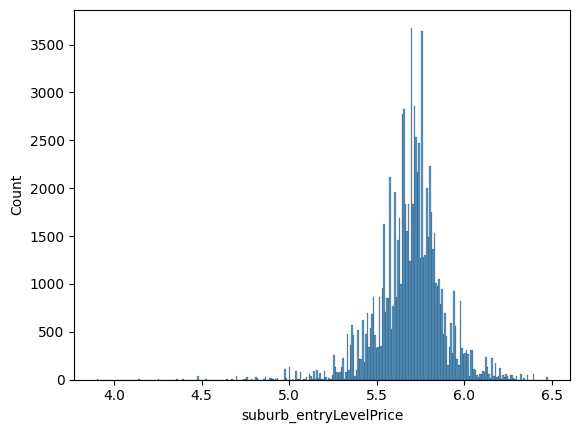

In [54]:
sns.histplot(np.log10(train['suburb_entryLevelPrice']))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='suburb_luxuryLevelPrice', ylabel='Count'>

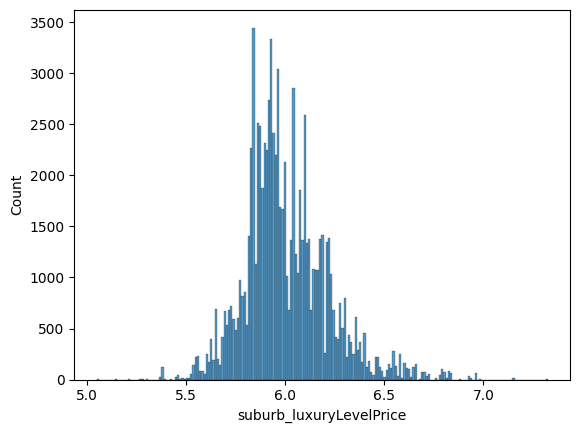

In [55]:
sns.histplot(np.log10(train['suburb_luxuryLevelPrice']))

Applying log10 transformation to the suburb features decreases the shape of the distribution

In [56]:
suburb_features = ['suburb_medianSoldPrice', 'suburb_medianRentPrice', 
                   'suburb_entryLevelPrice', 'suburb_luxuryLevelPrice']

# Choose a small constant to add
small_constant = 1e-6

for feature in suburb_features:
    train[feature] = train[feature].apply(lambda x: x if x==0 else np.log10(x))
    test[feature] = test[feature].apply(lambda x: x if x==0 else np.log10(x))

<Axes: xlabel='primaryDistance', ylabel='Count'>

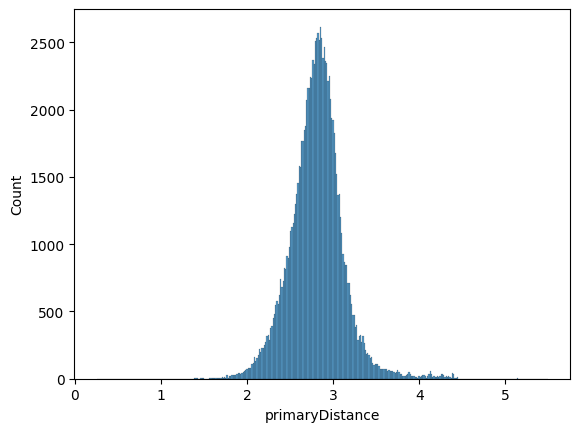

In [57]:
sns.histplot(np.log10(train['primaryDistance']))

<Axes: xlabel='secondaryDistance', ylabel='Count'>

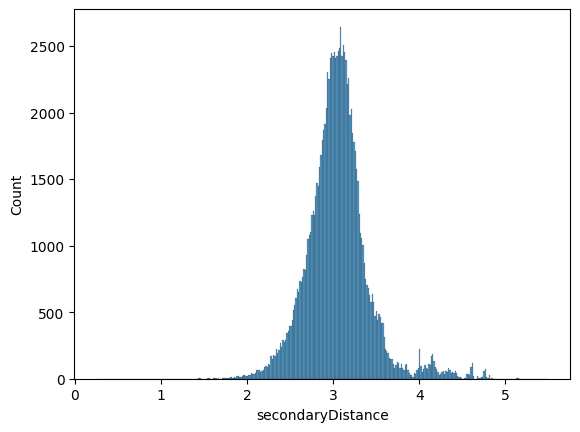

In [58]:
sns.histplot(np.log10(train['secondaryDistance']))

In [59]:
train['primaryDistance'] = train['primaryDistance'].apply(np.log10)
train['secondaryDistance'] = train['secondaryDistance'].apply(np.log10)

test['primaryDistance'] = test['primaryDistance'].apply(np.log10)
test['secondaryDistance'] = test['secondaryDistance'].apply(np.log10)

# One Hot Encoding

### features

In [60]:
# Finding the most common features
feature_dict = {}

for listing in train['features']:
    for feature in listing:
        if feature in feature_dict.keys():
            feature_dict[feature] += 1
        else:
            feature_dict[feature] = 1

In [61]:
dict(sorted(feature_dict.items(), key=lambda item: item[1], reverse=True))

{'air conditioning': 26379,
 'ensuite': 18894,
 'secure parking': 16497,
 'built in wardrobes': 13604,
 'dishwasher': 9742,
 'fully fenced': 9463,
 'close to shops': 8078,
 'close to schools': 8001,
 'built-in wardrobes': 7690,
 'close to transport': 7514,
 'shed': 6395,
 'study': 5859,
 'garden / courtyard': 5769,
 'internal laundry': 5007,
 'garden': 4942,
 'floorboards': 4389,
 'bath': 4348,
 'balcony / deck': 4237,
 'swimming pool': 4134,
 'solar panels': 3905,
 'gas': 3664,
 'alarm system': 3594,
 'heating': 3401,
 'remote garage': 3036,
 'fireplace(s)': 2603,
 'formal lounge': 2567,
 'pets allowed': 2476,
 'outdoor entertaining': 2321,
 'broadband internet access': 2004,
 'separate dining room': 1711,
 'pool': 1689,
 'outdoor entertainment area': 1604,
 'wall / ceiling insulation': 1580,
 'separate dining': 1439,
 'intercom': 1259,
 'polished timber floor': 1217,
 'built-in robes': 1157,
 'workshop': 1133,
 'water views': 1113,
 'solar hot water': 1103,
 'balcony': 1102,
 'air-co

In [62]:
synonym_mapping = {
    # Air Conditioning
    'air-conditioning': 'air conditioning',
    'air-conditioner': 'air conditioning',
    'reverse cycle air conditioning': 'air conditioning',
    'evaporative cooling': 'air conditioning',
    'split-system air conditioning': 'air conditioning',
    'split system ac': 'air conditioning',
    'split system heating': 'air conditioning',
    'ac': 'air conditioning',
    'reverse cycle ac': 'air conditioning',

    # Built-in Wardrobes
    'built-in wardrobes': 'built in wardrobes',
    'built-in robes': 'built in wardrobes',
    'built in robes': 'built in wardrobes',
    'builtin robes': 'built in wardrobes',

    # Outdoor Features
    'garden / courtyard': 'courtyard',
    'balcony / deck': 'balcony',
    'terrace-balcony': 'balcony',
    'outdoor entertaining': 'outdoor entertainment area',
    'outdoor entertainment': 'outdoor entertainment area',
    'entertainment area': 'outdoor entertainment area',
    'outside entertaining area': 'outdoor entertainment area',
    'alfresco': 'outdoor entertainment area',

    # Pools
    'swimming pool - in ground': 'swimming pool',
    'pool': 'swimming pool',
    'inground pool': 'swimming pool',
    'outdoor spa': 'swimming pool',

    # Heating and Fireplace
    'fireplace(s)': 'fireplace',
    'gas heating': 'heating',
    'split system heating': 'heating',
    'ducted heating': 'heating',
    'wall / ceiling insulation': 'heating',
    'insulation': 'heating',

    # Internet and Broadband
    'broadband internet access': 'broadband',
    'broadband internet available': 'broadband',
    'cable or satellite': 'broadband',

    # Solar and Energy
    'solar panels': 'solar panel',
    'solar hot water': 'solar panel',
    'rainwater storage tank': 'solar panel',
    'electric hot water service': 'solar panel',

    # Security
    'security alarm': 'alarm system',
    'alarm': 'alarm system',
    'security access': 'alarm system',
    'security system': 'alarm system',

    # Parking
    'car parking - surface': 'secure parking',
    'additional parking': 'secure parking',
    'side access': 'secure parking',

    # Rooms and Layout
    'study': 'study',
    'formal lounge': 'lounge',
    'rumpus room': 'lounge',
    'family room': 'lounge',
    'separate dining': 'dining room',
    'separate dining room': 'dining room',
    'kitchen/dining': 'dining room',
    'theatre': 'lounge',
    'games room': 'lounge',

    # Miscellaneous
    'window treatments': 'blinds',
    'high ceilings': 'ceiling',
    'inside:': 'interior',
    'outside:': 'exterior',
    'pet friendly': 'pets allowed',
    'liveability': 'comfort',
    'first home buyer': 'starter home',
    'city views': 'area views',
    'water views': 'area views',
}

# Clean the features column
def clean_features(feature_list):
    # Replace synonyms
    cleaned = [synonym_mapping.get(feature, feature) for feature in feature_list]
    # Remove duplicates
    return list(set(cleaned))

# Apply the cleaning function to train and test datasets
train['features'] = train['features'].apply(clean_features)
test['features'] = test['features'].apply(clean_features)


In [63]:
# Reviewing most common features
feature_dict = {}

for listing in train['features']:
    for feature in listing:
        if feature in feature_dict.keys():
            feature_dict[feature] += 1
        else:
            feature_dict[feature] = 1
            
dict(sorted(feature_dict.items(), key=lambda item: item[1], reverse=True))

{'air conditioning': 28894,
 'built in wardrobes': 23318,
 'ensuite': 18893,
 'secure parking': 16658,
 'dishwasher': 9738,
 'fully fenced': 9458,
 'close to shops': 8076,
 'close to schools': 8000,
 'close to transport': 7513,
 'courtyard': 6789,
 'swimming pool': 6611,
 'shed': 6388,
 'balcony': 6261,
 'study': 5840,
 'heating': 5397,
 'solar panel': 5218,
 'outdoor entertainment area': 5196,
 'internal laundry': 5007,
 'alarm system': 4983,
 'garden': 4941,
 'floorboards': 4389,
 'bath': 4347,
 'lounge': 3865,
 'dining room': 3476,
 'remote garage': 3036,
 'broadband': 2847,
 'fireplace': 2827,
 'pets allowed': 2659,
 'gas': 2275,
 'area views': 1907,
 'intercom': 1258,
 'polished timber floor': 1217,
 'workshop': 1133,
 'ensuite(s)': 879,
 'ground floor': 842,
 'gym': 814,
 'blinds': 769,
 'north facing': 671,
 'patio': 665,
 'gas hot water service': 567,
 'carpeted': 555,
 'ducted cooling': 545,
 'starter home': 543,
 'deck': 456,
 'ceiling': 398,
 'reticulation': 331,
 'indoor sp

In [64]:
# Selecting only features that have a count greater than 1000
feature_dict = {key: value for key, value in feature_dict.items() if value >= 9000}

In [65]:
# Perform one-hot encoding for the most frequent features
selected_features = list(feature_dict.keys())

for feature in selected_features:
    train[f'feature_{feature.replace(" ", "_")}'] = train['features'].apply(lambda x: 1 if feature in x else 0)
    test[f'feature_{feature.replace(" ", "_")}'] = test['features'].apply(lambda x: 1 if feature in x else 0)

# Removing original column
train.drop(columns=['features'], inplace=True)
test.drop(columns=['features'], inplace=True)

In [66]:
train.columns

Index(['streetNumber', 'street', 'suburb', 'postcode', 'bathrooms', 'bedrooms',
       'parking', 'landArea', 'latitude', 'longitude', 'propertyType',
       'soldYear', 'soldPrice', 'suburb_marriedPercentage',
       'suburb_population', 'suburb_renterPercentage',
       'suburb_mostCommonAgeBracket', 'suburb_medianSoldPrice',
       'suburb_medianRentPrice', 'suburb_entryLevelPrice',
       'suburb_luxuryLevelPrice', 'primary_school', 'primaryDistance',
       'primaryType', 'primaryICSEA', 'secondary_school', 'secondaryDistance',
       'secondaryType', 'secondaryICSEA', 'feature_built_in_wardrobes',
       'feature_air_conditioning', 'feature_secure_parking', 'feature_ensuite',
       'feature_dishwasher', 'feature_fully_fenced'],
      dtype='object')

### propertyType, primaryType, secondaryType

In [67]:
def ohe_transform(df, transformer, cat_cols):
    '''
    - Performs one hot encoding on selected categorical variables on a df
    - Encoder must be made prior to running this function
    '''
    # Encoding
    transformed = transformer.transform(df[cat_cols])
    
    # Check if the output of transform needs to be converted to an array
    if hasattr(transformed, 'toarray'):
        transformed = transformed.toarray()  # Convert sparse matrix to a dense array
    # If it's already a numpy array, no conversion is needed

    # Reformatting OHE column names
    transformer_names = transformer.get_feature_names_out()
    ohe_names = [name.split('__', 1)[-1] for name in transformer_names]
    
    # Converting back to dataframe
    transformed_df = pd.DataFrame(transformed, columns=ohe_names, index=df.index)
    
    # Joining OHE df with other numerical features
    df = pd.concat([df.drop(columns=cat_cols), transformed_df], axis=1)
    
    return df


In [68]:
cat_cols = ['propertyType','suburb_mostCommonAgeBracket','primaryType','secondaryType']
# Create encoder handle_unknown ensures that unseen values in the test set are ignored
t = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), ['propertyType','suburb_mostCommonAgeBracket',
                                                                      'primaryType','secondaryType']))
t.fit(train)

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['propertyType', 'suburb_mostCommonAgeBracket',
                                  'primaryType', 'secondaryType'])])

In [69]:
train = ohe_transform(train,t,cat_cols)
test = ohe_transform(test,t,cat_cols)

In [70]:
train.columns

Index(['streetNumber', 'street', 'suburb', 'postcode', 'bathrooms', 'bedrooms',
       'parking', 'landArea', 'latitude', 'longitude', 'soldYear', 'soldPrice',
       'suburb_marriedPercentage', 'suburb_population',
       'suburb_renterPercentage', 'suburb_medianSoldPrice',
       'suburb_medianRentPrice', 'suburb_entryLevelPrice',
       'suburb_luxuryLevelPrice', 'primary_school', 'primaryDistance',
       'primaryICSEA', 'secondary_school', 'secondaryDistance',
       'secondaryICSEA', 'feature_built_in_wardrobes',
       'feature_air_conditioning', 'feature_secure_parking', 'feature_ensuite',
       'feature_dishwasher', 'feature_fully_fenced', 'propertyType_house',
       'propertyType_unit', 'suburb_mostCommonAgeBracket_0',
       'suburb_mostCommonAgeBracket_20 to 39',
       'suburb_mostCommonAgeBracket_40 to 59',
       'suburb_mostCommonAgeBracket_5 to 19',
       'suburb_mostCommonAgeBracket_60+', 'primaryType_combined',
       'primaryType_primary', 'secondaryType_combined

# Geospatial features

### coastDistance 
For each property listing, find the distance to the nearest coastline

In [71]:
# Load the coastline shapefile
coastline_global = gpd.read_file("/Users/tristangarcia/desktop/hp-pred/data/ne_50m_coastline/ne_50m_coastline.shp")

# Filter coastline for Australia
australia_bounds = {
    "minx": 112.0,
    "maxx": 154.0,
    "miny": -44.0,
    "maxy": -10.0
}
australian_coastline = coastline_global.cx[
    australia_bounds["minx"]:australia_bounds["maxx"],
    australia_bounds["miny"]:australia_bounds["maxy"]
]

# Reproject coastline to a projected CRS (Australia Albers)
australian_coastline = australian_coastline.to_crs("EPSG:3577")

def calculate_distance(df, coastline):
    # Convert the DataFrame to a GeoDataFrame
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    
    # Reproject to the same CRS as the coastline
    gdf = gdf.to_crs("EPSG:3577")
    
    # Calculate distances and add them as a new column
    df['coastDistance'] = gdf.geometry.apply(
        lambda point: coastline.distance(point).min()
    )
    
    # Drop the geometry column and return the updated DataFrame
    return df.drop(columns=['geometry'])

# Calculate distances for train and test sets
train = calculate_distance(train, australian_coastline).reset_index(drop=True)
test = calculate_distance(test, australian_coastline).reset_index(drop=True)

In [72]:
# Check results
print(train[['latitude', 'longitude', 'coastDistance']].head())

   latitude  longitude  coastDistance
0    -32.29     115.73         179.24
1    -32.08     115.85       11193.96
2    -31.78     115.73        1701.12
3    -31.90     115.84        9853.03
4    -31.72     115.77        5693.49


<Axes: xlabel='coastDistance', ylabel='Count'>

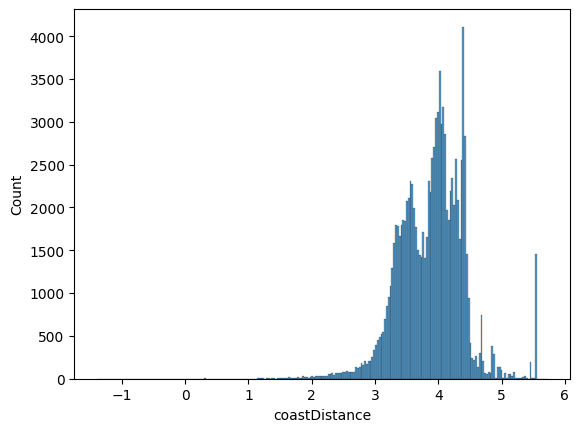

In [73]:
sns.histplot(np.log10(train['coastDistance']))

In [74]:
train['coastDistance'] = train['coastDistance'].apply(lambda x: x if x == 0 else np.log10(x))
test['coastDistance'] = test['coastDistance'].apply(lambda x: x if x == 0 else np.log10(x))

### cbdDistance
For each property listing, find the distance to Perth CBD

In [75]:
# CBD coordinates for Perth
perth_cbd_coords = (-31.9514, 115.8617)

def calculate_cbd_distance(df, cbd_coords):
    # Calculate geodesic distance for each row in meters
    df['cbdDistance'] = df.apply(
        lambda row: geodesic((row['latitude'], row['longitude']), cbd_coords).meters, axis=1
    )
    return df

# Calculate distances for train and test sets in meters
train = calculate_cbd_distance(train, perth_cbd_coords).reset_index(drop=True)
test = calculate_cbd_distance(test, perth_cbd_coords).reset_index(drop=True)

In [76]:
# Check results
print(train[['latitude', 'longitude', 'cbdDistance']].head())

   latitude  longitude  cbdDistance
0    -32.29     115.73     39286.96
1    -32.08     115.85     14285.11
2    -31.78     115.73     22717.73
3    -31.90     115.84      6145.99
4    -31.72     115.77     26691.26


<Axes: xlabel='cbdDistance', ylabel='Count'>

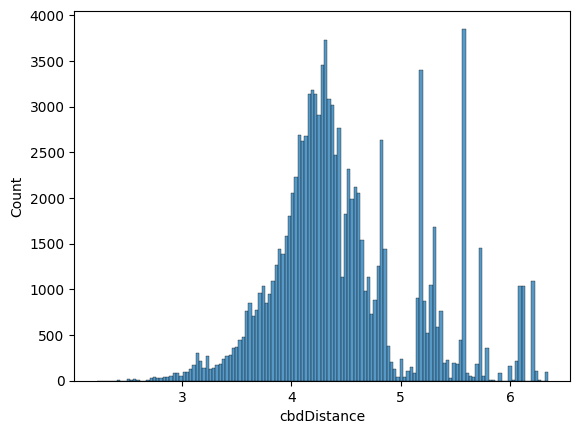

In [77]:
sns.histplot(np.log10(train['cbdDistance']))

In [78]:
train['cbdDistance'] = train['cbdDistance'].apply(lambda x: x if x == 0 else np.log10(x))
test['cbdDistance'] = test['cbdDistance'].apply(lambda x: x if x == 0 else np.log10(x))

# Standardisation

In [79]:
train.columns

Index(['streetNumber', 'street', 'suburb', 'postcode', 'bathrooms', 'bedrooms',
       'parking', 'landArea', 'latitude', 'longitude', 'soldYear', 'soldPrice',
       'suburb_marriedPercentage', 'suburb_population',
       'suburb_renterPercentage', 'suburb_medianSoldPrice',
       'suburb_medianRentPrice', 'suburb_entryLevelPrice',
       'suburb_luxuryLevelPrice', 'primary_school', 'primaryDistance',
       'primaryICSEA', 'secondary_school', 'secondaryDistance',
       'secondaryICSEA', 'feature_built_in_wardrobes',
       'feature_air_conditioning', 'feature_secure_parking', 'feature_ensuite',
       'feature_dishwasher', 'feature_fully_fenced', 'propertyType_house',
       'propertyType_unit', 'suburb_mostCommonAgeBracket_0',
       'suburb_mostCommonAgeBracket_20 to 39',
       'suburb_mostCommonAgeBracket_40 to 59',
       'suburb_mostCommonAgeBracket_5 to 19',
       'suburb_mostCommonAgeBracket_60+', 'primaryType_combined',
       'primaryType_primary', 'secondaryType_combined

In [80]:
std_features = ['bathrooms','bedrooms','parking','landArea', 'suburb_marriedPercentage',
                'suburb_population','suburb_renterPercentage','suburb_medianSoldPrice',
                'suburb_medianRentPrice','suburb_entryLevelPrice','suburb_luxuryLevelPrice',
                'primaryDistance','primaryICSEA','secondaryDistance',
                'secondaryICSEA','coastDistance','cbdDistance','latitude','longitude']

train[std_features] = train[std_features].astype(np.float64)
test[std_features] = test[std_features].astype(np.float64)

scaler = StandardScaler()
scaler.fit(train[std_features])

StandardScaler()

In [81]:
train.loc[:, std_features] = scaler.transform(train[std_features])
test.loc[:, std_features] = scaler.transform(test[std_features])

# Removing irrelevant columns

In [82]:
# Dropping the irrelevant columns
train = train.drop(columns=['suburb','street','streetNumber','postcode','soldMonth','soldYear','primary_school','secondary_school'], 
                   errors='ignore')

test = test.drop(columns=['suburb','street','streetNumber','postcode','soldMonth','soldYear','primary_school','secondary_school'], 
                 errors='ignore')



In [83]:
train.columns

Index(['bathrooms', 'bedrooms', 'parking', 'landArea', 'latitude', 'longitude',
       'soldPrice', 'suburb_marriedPercentage', 'suburb_population',
       'suburb_renterPercentage', 'suburb_medianSoldPrice',
       'suburb_medianRentPrice', 'suburb_entryLevelPrice',
       'suburb_luxuryLevelPrice', 'primaryDistance', 'primaryICSEA',
       'secondaryDistance', 'secondaryICSEA', 'feature_built_in_wardrobes',
       'feature_air_conditioning', 'feature_secure_parking', 'feature_ensuite',
       'feature_dishwasher', 'feature_fully_fenced', 'propertyType_house',
       'propertyType_unit', 'suburb_mostCommonAgeBracket_0',
       'suburb_mostCommonAgeBracket_20 to 39',
       'suburb_mostCommonAgeBracket_40 to 59',
       'suburb_mostCommonAgeBracket_5 to 19',
       'suburb_mostCommonAgeBracket_60+', 'primaryType_combined',
       'primaryType_primary', 'secondaryType_combined',
       'secondaryType_secondary', 'coastDistance', 'cbdDistance'],
      dtype='object')

# Feature selection

In [84]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [85]:
x_train = train.drop(columns=['soldPrice'])
y_train = train['soldPrice']

x_test = test.drop(columns=['soldPrice'])
y_test = test['soldPrice']

In [86]:
mse_values_linear = []
mse_values_xgb = []

for feature in x_train.columns:
    # Linear regression for univariate feature selection
    lin_reg = LinearRegression()
    lin_reg.fit(x_train[[feature]], y_train)
    y_pred_lr = lin_reg.predict(x_test[[feature]])
    mse_values_linear.append(mean_squared_error(y_test, y_pred_lr))

    # XGBoost for univariate feature selection
    xgb_reg = XGBRegressor()
    xgb_reg.fit(x_train[[feature]], y_train)
    y_pred_xgb = xgb_reg.predict(x_test[[feature]])
    mse_values_xgb.append(mean_squared_error(y_test, y_pred_xgb))

# Store MSE results in DataFrames
mse_linear = pd.Series(mse_values_linear, index=x_train.columns)
mse_xgb = pd.Series(mse_values_xgb, index=x_train.columns)

In [87]:
# Display ranking of features by MSE (lower is better)
mse_linear.sort_values(inplace=True)
mse_xgb.sort_values(inplace=True)

print("Top Features by Linear Regression MSE:\n", mse_linear.head())
print()
print("Top Features by XGBoost MSE:\n", mse_xgb.head())

Top Features by Linear Regression MSE:
 bathrooms            0.04
bedrooms             0.04
cbdDistance          0.04
propertyType_unit    0.04
propertyType_house   0.04
dtype: float64

Top Features by XGBoost MSE:
 suburb_medianSoldPrice    0.02
suburb_entryLevelPrice    0.02
suburb_luxuryLevelPrice   0.02
suburb_medianRentPrice    0.03
secondaryICSEA            0.03
dtype: float64


<Axes: >

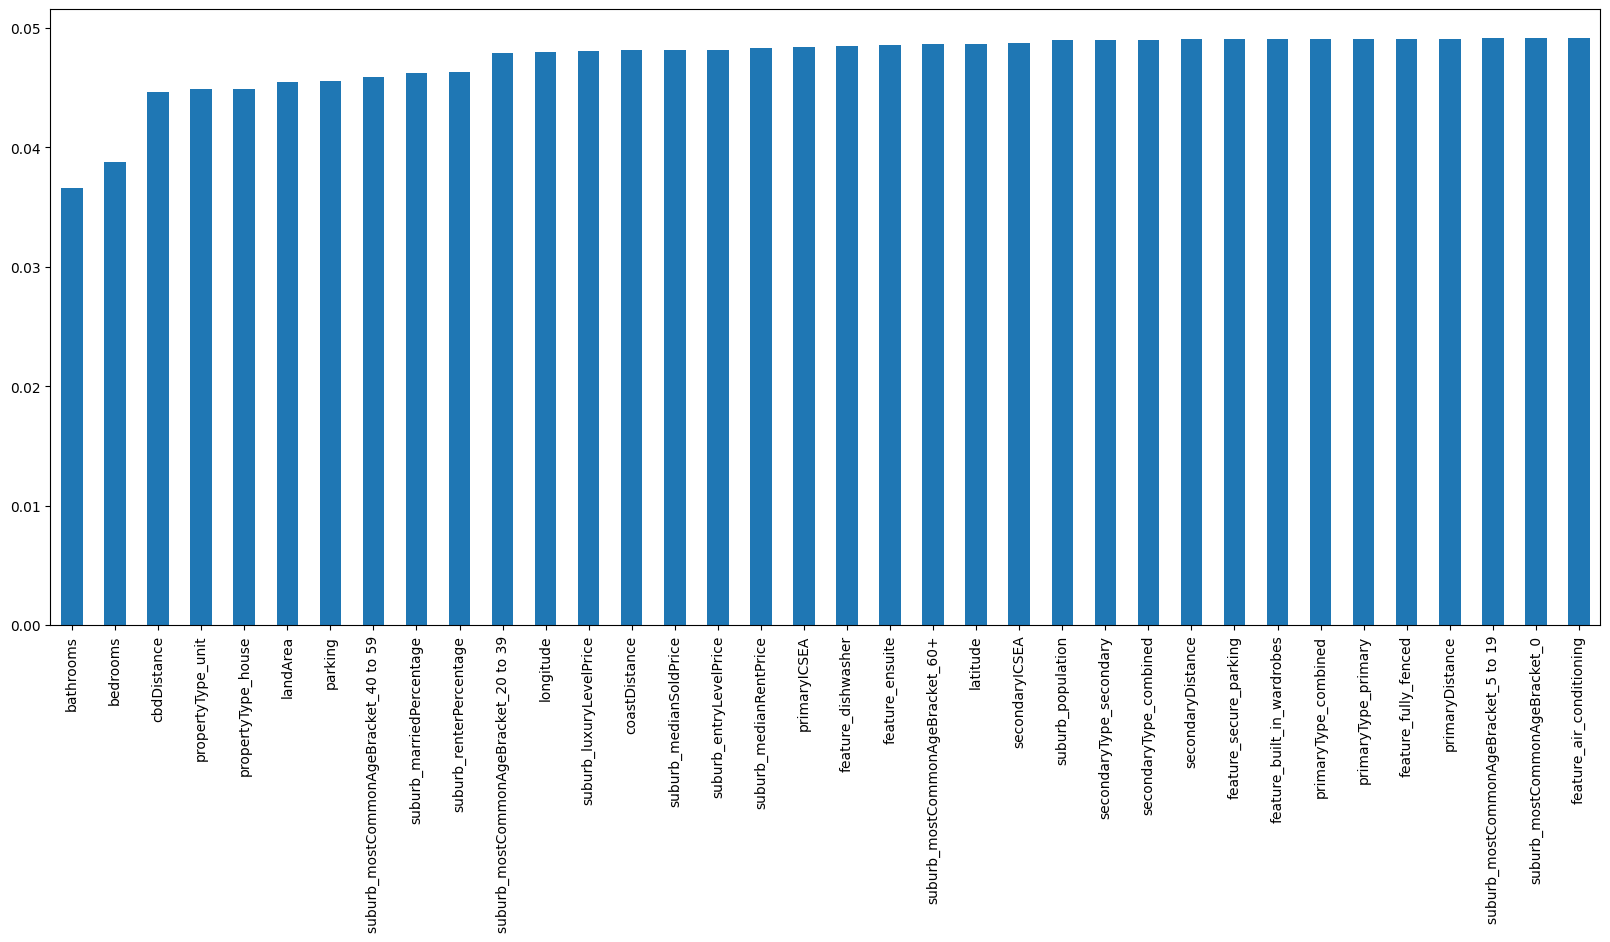

In [88]:
mse_linear.sort_values(ascending=True).plot.bar(figsize=(20,8))

<Axes: >

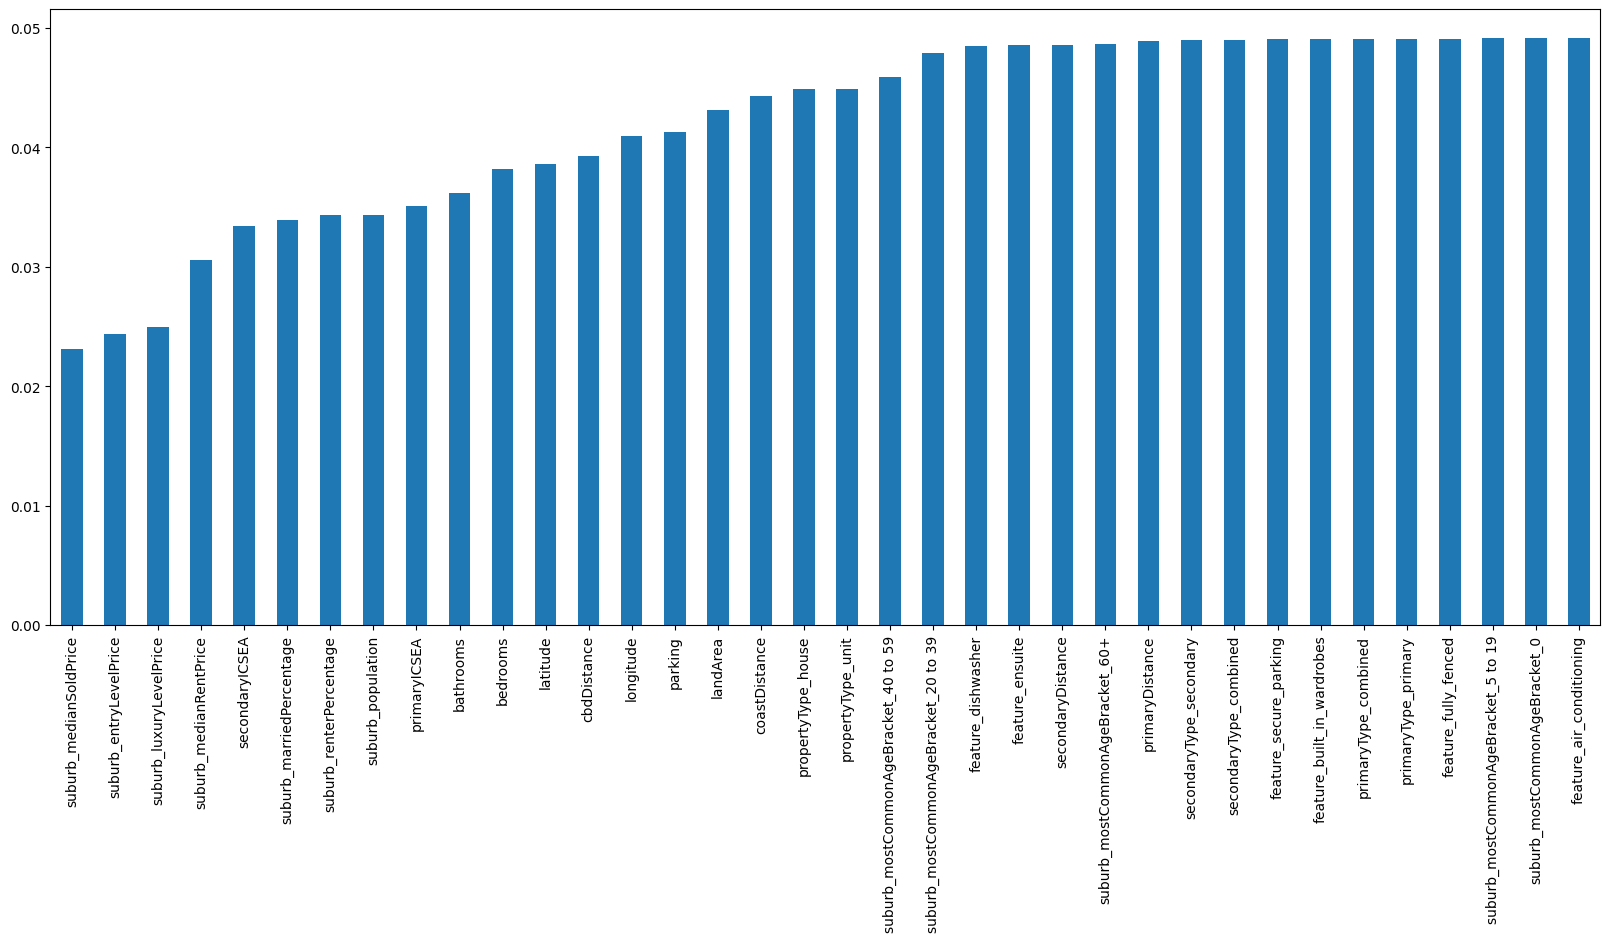

In [89]:
mse_xgb.sort_values(ascending=True).plot.bar(figsize=(20,8))

# Writing to csv

In [90]:
train.shape

(108128, 37)

In [91]:
train.to_pickle(f'{path}wa_train_final.pkl')
test.to_pickle(f'{path}wa_validation_final.pkl')